*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2020-12-29 14:13:43--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip      [   <=>              ]  24.88M  43.6MB/s    in 0.6s    

2020-12-29 14:13:44 (43.6 MB/s) - ‘book-crossings.zip’ saved [26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

----------------------------------------------------
---- df_books head ----
         isbn  ...                author
0  0195153448  ...    Mark P. O. Morford
1  0002005018  ...  Richard Bruce Wright
2  0060973129  ...          Carlo D'Este
3  0374157065  ...      Gina Bari Kolata
4  0393045218  ...       E. J. W. Barber

[5 rows x 3 columns]
---- df_books description ----
              isbn           title           author
count       271379          271379           271378
unique      271379          242154           102042
top     0704340070  Selected Poems  Agatha Christie
freq             1              27              632
---- df_books example ----
isbn               0195153448
title     Classical Mythology
author     Mark P. O. Morford
Name: 0, dtype: object
isbn = 0195153448
title = Classical Mythology
author = Mark P. O. Morford
----------------------------------------------------
---- df_ratings head ----
     user        isbn  rating
0  276725  034545104X     0.0
1  276726  

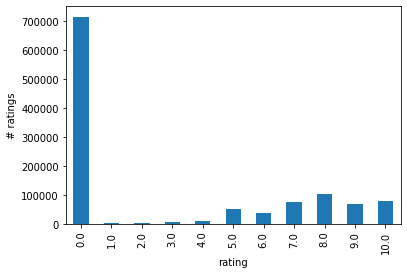

In [4]:
# add your code here - consider creating a new cell for each section of code

# print and plot some data for insight
print("----------------------------------------------------")
print("---- df_books head ----")
print(df_books.head())
print("---- df_books description ----")
print(df_books.describe())
print("---- df_books example ----")
print(df_books.loc[0])
print("isbn =",  df_books.loc[0].get("isbn"))
print("title =",  df_books.loc[0].get("title"))
print("author =", df_books.loc[0].get("author"))
print("----------------------------------------------------")
print("---- df_ratings head ----")
print(df_ratings.head())
print("---- df_ratings description ----")
print(df_ratings.describe())
print("---- df_ratings example ----")
print(df_ratings.loc[1])
print("user =", df_ratings.loc[1].get("user"))
print("isbn =", df_ratings.loc[1].get("isbn"))
print("rating =", df_ratings.loc[1].get("rating"))
print("---- df_ratings ratings ----")
print(df_ratings.rating.value_counts(sort=False).sort_index())
df_ratings.rating.value_counts(sort=False).sort_values().sort_index().plot(kind='bar')
plt.xlabel("rating")
plt.ylabel("# ratings")
plt.show()

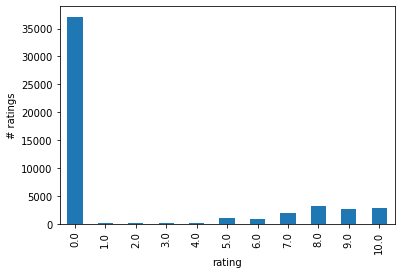

---- df_ratings description ----
                user        rating
count   49781.000000  49781.000000
mean   140993.388562      2.024086
std     80901.415891      3.576862
min       254.000000      0.000000
25%     70415.000000      0.000000
50%    140358.000000      0.000000
75%    213350.000000      3.000000
max    278418.000000     10.000000


In [5]:
# clean data and print statistics

# find users with less than 200 ratings
user_rating_counts = df_ratings['user'].value_counts()
valid_user_ratings = user_rating_counts[user_rating_counts >= 200]

# find books with less than 100 ratings
book_rating_counts = df_ratings['isbn'].value_counts()
valid_book_ratings = book_rating_counts[book_rating_counts >= 100]

# exclude found entries from df_ratings...
df_ratings = df_ratings[df_ratings['user'].isin(valid_user_ratings.index)]
df_ratings = df_ratings[df_ratings['isbn'].isin(valid_book_ratings.index)]

# ...and print plot 
df_ratings.rating.value_counts(sort=False).sort_values().sort_index().plot(kind='bar')
plt.xlabel("rating")
plt.ylabel("# ratings")
plt.show()

print("---- df_ratings description ----")
print(df_ratings.describe())

In [6]:
# merge/combine the data sets
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 200)

combined_ratings = pd.merge(df_ratings, df_books, on="isbn")
combined_ratings = combined_ratings.drop(["author"], axis=1)
print(combined_ratings)

         user        isbn  rating                                              title
0      277427  002542730X    10.0  Politically Correct Bedtime Stories: Modern Ta...
1        3363  002542730X     0.0  Politically Correct Bedtime Stories: Modern Ta...
2       11676  002542730X     6.0  Politically Correct Bedtime Stories: Modern Ta...
3       12538  002542730X    10.0  Politically Correct Bedtime Stories: Modern Ta...
4       13552  002542730X     0.0  Politically Correct Bedtime Stories: Modern Ta...
...       ...         ...     ...                                                ...
49512  238864  0399149325     0.0  Portrait of a Killer: Jack the Ripper -- Case ...
49513  251843  0399149325     1.0  Portrait of a Killer: Jack the Ripper -- Case ...
49514  253821  0399149325     0.0  Portrait of a Killer: Jack the Ripper -- Case ...
49515  265115  0399149325     0.0  Portrait of a Killer: Jack the Ripper -- Case ...
49516  266226  0399149325     0.0  Portrait of a Killer: Jack the

In [7]:
# clean data and pivot to get 'rating per book title per user'...
user_ratings_singled = combined_ratings.drop_duplicates(["user", "title"])
user_ratings_pivot = user_ratings_singled.pivot(index="title", columns="user", values="rating").fillna(0)
print(user_ratings_pivot)

print("---------------------------")
# ...and save in a csr matrix
user_ratings_matrix = csr_matrix(user_ratings_pivot.values)
print(user_ratings_matrix)
print(user_ratings_matrix.shape)

user                                                254     2276    2766    2977    3363    ...  275970  277427  277478  277639  278418
title                                                                                       ...                                        
1984                                                   9.0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0
1st to Die: A Novel                                    0.0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0
2nd Chance                                             0.0    10.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0
4 Blondes                                              0.0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0
A Beautiful Mind: The Life of Mathematical Geni...     0.0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0
...                                             

In [8]:
# check which metrics can be used for brute algorithm
from sklearn.neighbors import VALID_METRICS_SPARSE
print(VALID_METRICS_SPARSE['brute'])

# define and fit the knn model
model = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=5)
model.fit(user_ratings_matrix)

{'euclidean', 'manhattan', 'cosine', 'cityblock', 'l2', 'l1', 'precomputed'}


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [9]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
    query = user_ratings_pivot.loc[book].values.reshape(1,-1)
    distances, indices = model.kneighbors(query, n_neighbors=6)
    distances, indices = distances.flatten(), indices.flatten()
    recommended_books = [book]
    neighboring_books = []
    for i in range(1, len(indices)):
        entry = [ user_ratings_pivot.iloc[indices[i],:].name, distances[i] ]
        # insert entry at beginning to ensure correct ordering
        neighboring_books.insert(0, entry)
    recommended_books.append(neighboring_books)

    return recommended_books

In [10]:
get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")

['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [['Catch 22', 0.7939835],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.74486566],
  ['Interview with the Vampire', 0.73450685],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.51784116]]]

Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [11]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You havn't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
